In [1]:
# read nc output from WAOM 4km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

#import iris
#import iris.iterate
#import iris.coords
#import iris.plot as iplt
import gsw

In [2]:
dg4 = xr.open_dataset("/scratch/project_2000789/boeiradi/waom4_frc/waom4extend_grd.nc")
lat_rho_4km = dg4.variables["lat_rho"]
lon_rho_4km = dg4.variables["lon_rho"]
cor_4km = dg4.variables["f"]
pm_4km = dg4.variables["pm"]
pn_4km = dg4.variables["pn"]
dg4.close()

In [3]:
# create mask per longitude: Weddell, Maud Land, East Antarctica, Ross, West Antarctica
import matplotlib.path as mpath
import cartopy.feature as cfeature

# 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
mask_Wed1lon = ma.masked_where(lon_rho_4km <= -90, np.ones(lon_rho_4km.shape)) # West limit for lat<-75
mask_Wed1lat = ma.masked_where(lat_rho_4km > -75, np.ones(lat_rho_4km.shape))
mask_Wed1 = mask_Wed1lon*mask_Wed1lat

mask_Wed2lon = ma.masked_where(lon_rho_4km <= -65, np.ones(lon_rho_4km.shape)) # West limit for lat<-75
mask_Wed2lat = ma.masked_where(lat_rho_4km <= -75, np.ones(lat_rho_4km.shape))
mask_Wed2 = mask_Wed2lon*mask_Wed2lat

mask_Wed12 = np.ma.array(mask_Wed1.filled(1) * mask_Wed2.filled(1), mask=(mask_Wed1.mask * mask_Wed2.mask))

mask_Wed3= ma.masked_where(lon_rho_4km > -25, np.ones(lon_rho_4km.shape)) # East limit for any latitude

mask_Wed = mask_Wed12*mask_Wed3

# 2) Mask Maud Land (25W : 60E, lat < -60)

mask_Mau1lon = ma.masked_where(lon_rho_4km <= -25, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_Mau1lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_Mau1 = mask_Mau1lon*mask_Mau1lat

mask_Mau2lon = ma.masked_where(lon_rho_4km >= 60, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_Mau2lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_Mau2 = mask_Mau2lon*mask_Mau2lat

mask_Mau = mask_Mau1*mask_Mau2

# 3) Mask East Antarctica (60E : 160E, lat < -60)

mask_EAnt1lon = ma.masked_where(lon_rho_4km < 60, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_EAnt1lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_EAnt1 = mask_EAnt1lon*mask_EAnt1lat

mask_EAnt2lon = ma.masked_where(lon_rho_4km >= 160, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_EAnt2lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_EAnt2 = mask_EAnt2lon*mask_EAnt2lat

mask_EAnt = mask_EAnt1*mask_EAnt2

# 4) Mask Ross (140W : 160E, lat < -60)

mask_Ros1lon = ma.masked_where(lon_rho_4km < 160, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_Ros1lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_Ros1 = mask_Ros1lon*mask_Ros1lat

mask_Ros2lon = ma.masked_where(lon_rho_4km >= -150, np.ones(lon_rho_4km.shape)) # East limit for any latitude
mask_Ros2lat = ma.masked_where(lat_rho_4km > -60, np.ones(lat_rho_4km.shape))
mask_Ros2 = mask_Ros2lon*mask_Ros2lat

mask_Ros = np.ma.array(mask_Ros1.filled(1) * mask_Ros2.filled(1), mask=(mask_Ros1.mask * mask_Ros2.mask))

# 5) Mask West Antarctica (150W : 90W, lat < -65)

mask_WAnt1 = ma.masked_where(lon_rho_4km < -150, np.ones(lon_rho_4km.shape)) # West limit for any latitude

mask_WAnt2lon = ma.masked_where(lon_rho_4km > -90, np.ones(lon_rho_4km.shape)) # East limit for lat <-73
mask_WAnt2lat = ma.masked_where(lat_rho_4km > -75, np.ones(lat_rho_4km.shape))
mask_WAnt2 = mask_WAnt2lon*mask_WAnt2lat

mask_WAnt3lon = ma.masked_where(lon_rho_4km > -65, np.ones(lon_rho_4km.shape)) # East limit for lat >-73
mask_WAnt3lat = ma.masked_where(lat_rho_4km <= -75, np.ones(lat_rho_4km.shape))
mask_WAnt3 = mask_WAnt3lon*mask_WAnt3lat

mask_WAnt23 = np.ma.array(mask_WAnt2.filled(1) * mask_WAnt3.filled(1), mask=(mask_WAnt2.mask * mask_WAnt3.mask))

mask_WAnt = mask_WAnt1*mask_WAnt23

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

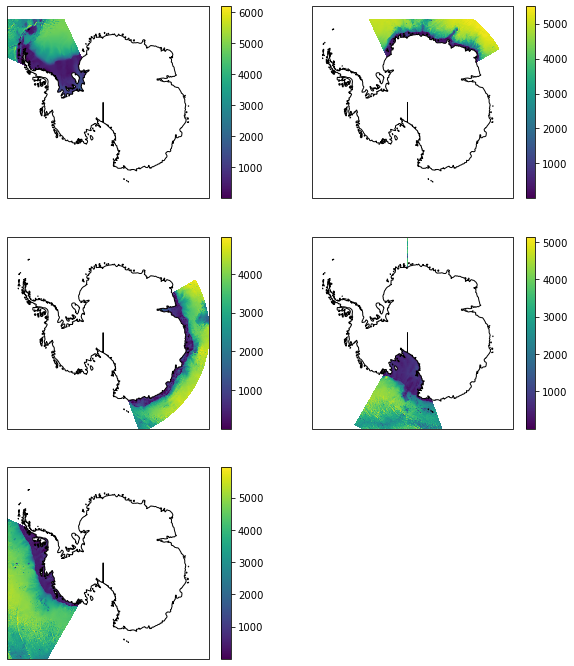

In [4]:
#
proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10,12))
# 1) Mask Weddell (90W : 25W, lat < -73, 65W : 25W, lat <= -73)
ax1 = fig.add_subplot(321, projection=proj)
cy=plt.pcolormesh(lon_rho_4km, lat_rho_4km, dg4.h*mask_Wed, transform=ccrs.PlateCarree())
plt.colorbar(cy)
ax1.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
# 2) Mask Maud Land (25W : 60E, lat < -60)
ax2 = fig.add_subplot(322, projection=proj)
cy=plt.pcolormesh(lon_rho_4km, lat_rho_4km, dg4.h*mask_Mau, transform=ccrs.PlateCarree())
plt.colorbar(cy)
ax2.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
# 3) Mask East Antarctica (60E : 160E, lat < -60)
ax3 = fig.add_subplot(323, projection=proj)
cy=plt.pcolormesh(lon_rho_4km, lat_rho_4km, dg4.h*mask_EAnt, transform=ccrs.PlateCarree())
plt.colorbar(cy)
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
# 4) Mask Ross (140W : 160E, lat < -60)
ax4 = fig.add_subplot(324, projection=proj)
cy=plt.pcolormesh(lon_rho_4km, lat_rho_4km, dg4.h*mask_Ros, transform=ccrs.PlateCarree())
plt.colorbar(cy)
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
# 5) Mask West Antarctica (140W : 90W, lat < -60)
ax5 = fig.add_subplot(325, projection=proj)
cy=plt.pcolormesh(lon_rho_4km, lat_rho_4km, dg4.h*mask_WAnt, transform=ccrs.PlateCarree())
plt.colorbar(cy)
ax5.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
plt.show()

In [5]:
#
# read ROMS 4km:
def read_roms_ts_4km(exp_path):
    for yr  in ['01','02','03','04','05','06','07','08','09','10']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        print('size salt_tmp_ann = ', salt_tmp_ann.shape)
        del salt_tmp

        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        if ds.Vtransform == 1:
            Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
            z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
            print("Vtransform=1")
        elif ds.Vtransform == 2:
            Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
            z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
            print("Vtransform=2")
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # concantenate annual averaged salt
        if yr == '01':
            salt_ann = salt_tmp_ann
            z_w_ann = z_w_tmp_ann
            z_rho_ann = z_rho_tmp_ann
        elif yr == '02':
            salt_ann = np.stack((salt_ann,salt_tmp_ann), axis=0)
            z_w_ann = np.stack((z_w_ann,z_w_tmp_ann), axis=0)
            z_rho_ann = np.stack((z_rho_ann,z_rho_tmp_ann), axis=0)
        else:
            salt_tmp_ann_4thdim = np.expand_dims(salt_tmp_ann, axis=0)
            salt_ann = np.concatenate((salt_ann,salt_tmp_ann_4thdim), axis=0)
            z_w_tmp_ann_4thdim = np.expand_dims(z_w_tmp_ann, axis=0)
            z_w_ann = np.concatenate((z_w_ann,z_w_tmp_ann_4thdim), axis=0)
            z_rho_tmp_ann_4thdim = np.expand_dims(z_rho_tmp_ann, axis=0)
            z_rho_ann = np.concatenate((z_rho_ann,z_rho_tmp_ann_4thdim), axis=0)
            del salt_tmp_ann_4thdim, z_w_tmp_ann_4thdim, z_rho_tmp_ann_4thdim
        print('Annual salt and annual tmp temp sizes = ', salt_ann.shape, salt_tmp_ann.shape)
        print('Annual z_w and annual tmp z_w sizes = ', z_w_ann.shape, z_w_tmp_ann.shape)

        del salt_tmp_ann, z_w_tmp_ann, z_rho_tmp_ann

    print('Annual salt, z_w, z_rho sizes = ', salt_ann.shape, z_w_ann.shape, z_rho_ann.shape)

    # shelf/open-ocean masks:
    mask_shelf = np.empty((ds.h.shape))

    shelf_ind=ds.h.where(ds.h < 2000)
    #print(open_ind)

    mask_shelf = np.divide(shelf_ind,shelf_ind)

    # calculate dz following:
    dz = np.empty((10,1400,1575,31))
    dz_inv = np.empty((10,1400,1575,31))

    for tt in np.arange(0,10):
        z_w_sorted = -1*z_w_ann[tt,:,::-1]
        dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
        dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]

    print('size dz = ', dz.shape)

    # first, vertical integral:
    salt_dz = np.empty((10,31,1400,1575))

    for tt in np.arange(0,10):
        for zz in np.arange(30,-1,-1):
            salt_dz[tt,zz,:,:] = salt_ann[tt,zz,:,:]*dz[tt,:,:,zz]

    salt_vertint = np.nansum(salt_dz[:,::-1,:,:], axis=1)

    print('sizes salt_ann, salt_dz, salt_vertint = ', salt_ann.shape, salt_dz.shape, salt_vertint.shape)

    # horizontal integral
    p_area = ds.pm.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))*ds.pn.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))
    area = 1/p_area # area in meters

    print('size area = ', area.shape)
       
    salt_area_shelf = np.empty((10,1400,1575))
    salt_hint_shelf = np.empty((10,))
    salt_hintn_shelf = np.empty((10,))

    sectors = ['Wed','Mau','EAnt','Ros','WAnt']
    for sec in sectors:
#         print(sec)
        exec(' '.join(['salt_area_shelf_'+ sec +' = np.empty((10,1400,1575))'])) # ' '.join to convert from list to string
        exec(' '.join(['salt_hint_shelf_' + sec + ' = np.empty((10,))']))
        exec(' '.join(['salt_hintn_shelf_' + sec + ' = np.empty((10,))']))
        
    for tt in np.arange(0,10,1):
        # circum-Antarctic
        salt_area_shelf[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf
        salt_hint_shelf[tt] = np.nansum(np.nansum((salt_area_shelf[tt,:,:]), axis=1),axis=0)
        area_sum_shelf = np.nansum(np.nansum(area*mask_shelf, axis=1),axis=0)
        salt_hintn_shelf_Wed[tt] = np.divide(salt_hint_shelf[tt],area_sum_shelf)
        print('salt_area_shelf_Wed shape:', salt_area_shelf_Wed.shape)
        
        # sectors: Weddell
        salt_area_shelf_Wed[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf*mask_Wed
        salt_hint_shelf_Wed[tt] = np.nansum(np.nansum((salt_area_shelf_Wed[tt,:,:]), axis=1),axis=0)
        area_sum_shelf_Wed = np.nansum(np.nansum(area*mask_shelf*mask_Wed, axis=1),axis=0)       
        salt_hintn_shelf_Wed[tt] = np.divide(salt_hint_shelf_Wed[tt],area_sum_shelf_Wed)
        # sectors: Maud Land
        salt_area_shelf_Mau[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf*mask_Mau
        salt_hint_shelf_Mau[tt] = np.nansum(np.nansum((salt_area_shelf_Mau[tt,:,:]), axis=1),axis=0)
        area_sum_shelf_Mau = np.nansum(np.nansum(area*mask_shelf*mask_Mau, axis=1),axis=0)       
        salt_hintn_shelf_Mau[tt] = np.divide(salt_hint_shelf_Mau[tt],area_sum_shelf_Mau)
        # sectors: East Antarctica
        salt_area_shelf_EAnt[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf*mask_EAnt
        salt_hint_shelf_EAnt[tt] = np.nansum(np.nansum((salt_area_shelf_EAnt[tt,:,:]), axis=1),axis=0)
        area_sum_shelf_EAnt = np.nansum(np.nansum(area*mask_shelf*mask_EAnt, axis=1),axis=0)       
        salt_hintn_shelf_EAnt[tt] = np.divide(salt_hint_shelf_EAnt[tt],area_sum_shelf_EAnt)
        # sectors: Ross
        salt_area_shelf_Ros[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf*mask_Ros
        salt_hint_shelf_Ros[tt] = np.nansum(np.nansum((salt_area_shelf_Ros[tt,:,:]), axis=1),axis=0)
        area_sum_shelf_Ros = np.nansum(np.nansum(area*mask_shelf*mask_Ros, axis=1),axis=0)       
        salt_hintn_shelf_Ros[tt] = np.divide(salt_hint_shelf_Ros[tt],area_sum_shelf_Ros)        
        # sectors: West Antarctica
        salt_area_shelf_WAnt[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf*mask_WAnt
        salt_hint_shelf_WAnt[tt] = np.nansum(np.nansum((salt_area_shelf_WAnt[tt,:,:]), axis=1),axis=0)
        area_sum_shelf_WAnt = np.nansum(np.nansum(area*mask_shelf*mask_WAnt, axis=1),axis=0)       
        salt_hintn_shelf_WAnt[tt] = np.divide(salt_hint_shelf_WAnt[tt],area_sum_shelf_WAnt)
        
    SSS_havg_shelf = np.empty((10,))
    for sec in sectors:
        exec(' '.join(['SSS_havg_shelf_'+ sec +' = np.empty((10,))']))

    for tt in np.arange(0,10,1):
        SSS_havg_shelf[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)
        SSS_havg_shelf_Wed[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf*mask_Wed), axis=1),axis=0)
        SSS_havg_shelf_Mau[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf*mask_Mau), axis=1),axis=0)
        SSS_havg_shelf_EAnt[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf*mask_EAnt), axis=1),axis=0)
        SSS_havg_shelf_Ros[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf*mask_Ros), axis=1),axis=0)
        SSS_havg_shelf_WAnt[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf*mask_WAnt), axis=1),axis=0)


    return SSS_havg_shelf, SSS_havg_shelf_Wed, SSS_havg_shelf_Mau, SSS_havg_shelf_EAnt, SSS_havg_shelf_Ros, SSS_havg_shelf_WAnt, \
        salt_hintn_shelf, salt_hintn_shelf_Wed, salt_hintn_shelf_Mau, salt_hintn_shelf_EAnt, salt_hintn_shelf_Ros, salt_hintn_shelf_WAnt

In [ ]:
#
path_ECCO2_4km = '/scratch/project_2000789/boeiradi/waom4extend_shflim_S_0.25Q/output_01-10yr/'

# E4_SST_havg_shelf, E4_SSS_havg_shelf, E4_ohc_hintn_shelf, E4_salt_hintn_shelf, E4_MKE_havg_shelf = read_roms_ts_4km(path_ECCO2_4km)
E4_SSS_havg_shelf, E4_SSS_havg_shelf_Wed, E4_SSS_havg_shelf_Mau, E4_SSS_havg_shelf_EAnt, E4_SSS_havg_shelf_Ros, E4_SSS_havg_shelf_WAnt, \
    E4_salt_hintn_shelf, E4_salt_hintn_shelf_Wed, E4_salt_hintn_shelf_Mau, E4_salt_hintn_shelf_EAnt, E4_salt_hintn_shelf_Ros, E4_salt_hintn_shelf_WAnt = \
    read_roms_ts_4km(path_ECCO2_4km)



size temp and time length:  (12, 31, 1400, 1575) 12


/run/nvme/job_13322616/tmp/ipykernel_47497/475499567.py:9: RuntimeWarning: Mean of empty slice
  salt_tmp_ann = np.nanmean(salt_tmp, axis=0)


size salt_tmp_ann =  (31, 1400, 1575)


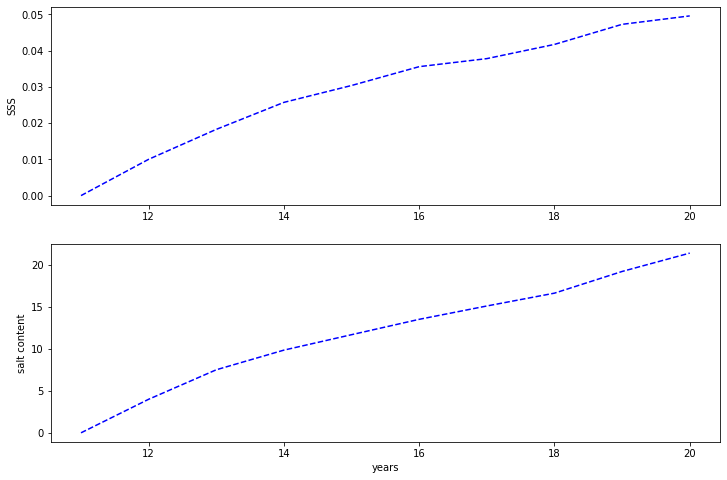

In [6]:
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Grid_avg/'

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plt.plot(np.arange(10,20)+1,E4_SSS_havg_shelf - E4_SSS_havg_shelf[0],'--b',label='4km')
plt.ylabel('SSS')
ax2 = fig.add_subplot(212)
plt.plot(np.arange(10,20)+1,-E4_salt_hintn_shelf + E4_salt_hintn_shelf[0],'--b',label='4km')
plt.ylabel('salt content')
plt.xlabel('years')
plt.show()

In [7]:
sectors = ['Wed','Mau','EAnt','Ros','WAnt']
for sec in sectors:
    print(sec)
#     line1 = ' '.join(['salt_area_shelf_'+ sec +' = np.empty((10,1400,1575))'])
#     print(type(line1))
    exec(' '.join(['salt_area_shelf_'+ sec +' = np.empty((10,1400,1575))']))
    exec(' '.join(['salt_hint_shelf' + sec + ' = np.empty((10,))']))
    exec(' '.join(['salt_hintn_shelf' + sec + ' = np.empty((10,))']))
    print('salt_area_shelf_Wed shape:', salt_area_shelf_Wed.shape)

Wed
salt_area_shelf_Wed shape: (10, 1400, 1575)
Mau
salt_area_shelf_Wed shape: (10, 1400, 1575)
EAnt
salt_area_shelf_Wed shape: (10, 1400, 1575)
Ros
salt_area_shelf_Wed shape: (10, 1400, 1575)
WAnt
salt_area_shelf_Wed shape: (10, 1400, 1575)


In [3]:
# # read ROMS 4km:
# def read_roms_ts_4km(exp_path):
#     for yr  in ['01','02','03','04','05','06','07','08','09','10']:
#         ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
#         print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
#         temp_tmp = ds.variables["temp"]
#         salt_tmp = ds.variables["salt"]
#         zeta_tmp = ds.variables["zeta"]
#         temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
#         salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
#         print('size temp_tmp_ann = ', temp_tmp_ann.shape)
#         del temp_tmp, salt_tmp

#         # calculate geostrophic velocities from ssh:
#         g = 9.81
#         dzetady = np.diff(zeta_tmp, axis=1)
#         dzetadx = np.diff(zeta_tmp, axis=2)
#         mmax = len(zeta_tmp)
#         dzeta_dy = np.empty((dzetady[:,:,0:-1].shape))
#         dzeta_dx = np.empty((dzetadx[:,0:-1,:].shape))
#         for mm in np.arange(0,mmax,1):
#             dzeta_dy[mm,:,:] = dzetady[mm,:,0:-1]*pn_4km[0:-1,0:-1]
#             dzeta_dx[mm,:,:]= dzetadx[mm,0:-1,:]*pm_4km[0:-1,0:-1]
#         ugeo = np.empty((dzeta_dy.shape))
#         vgeo = np.empty((dzeta_dx.shape))
#         for mm in np.arange(0,mmax,1):
#             ugeo[mm,:,:] = -(g/cor_4km[0:-1,0:-1])*dzeta_dy[mm,:,:]
#             vgeo[mm,:,:] = (g/cor_4km[0:-1,0:-1])*dzeta_dx[mm,:,:]
#         ugeo_ann_tmp = np.nanmean(ugeo, axis=0)
#         vgeo_ann_tmp = np.nanmean(vgeo, axis=0)
#         #ugeo_anom_tmp = ugeo - ugeo_ann
#         #vgeo_anom_tmp = vgeo - vgeo_ann
#         V_ann_tmp = np.sqrt(ugeo_ann_tmp*ugeo_ann_tmp + vgeo_ann_tmp*vgeo_ann_tmp)
#         MKE_tmp = np.divide(V_ann_tmp*V_ann_tmp,2)
#         print("Size MKE_tmp", MKE_tmp.shape)

#         ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

#         if ds.Vtransform == 1:
#             Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
#             z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
#             print("Vtransform=1")
#         elif ds.Vtransform == 2:
#             Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#             z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho
#             print("Vtransform=2")
#         z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

#         Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
#         z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w
#         z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)
        

#         # concantenate annual averaged temp/salt
#         if yr == '01':
#             temp_ann = temp_tmp_ann
#             salt_ann = salt_tmp_ann
#             z_w_ann = z_w_tmp_ann
#             z_rho_ann = z_rho_tmp_ann
#             MKE_ann = MKE_tmp
#         elif yr == '02':
#             temp_ann = np.stack((temp_ann,temp_tmp_ann), axis=0)
#             salt_ann = np.stack((salt_ann,salt_tmp_ann), axis=0)
#             z_w_ann = np.stack((z_w_ann,z_w_tmp_ann), axis=0)
#             z_rho_ann = np.stack((z_rho_ann,z_rho_tmp_ann), axis=0)
#             MKE_ann = np.stack((MKE_ann,MKE_tmp), axis=0)
#         else:
#             temp_tmp_ann_4thdim = np.expand_dims(temp_tmp_ann, axis=0)
#             temp_ann = np.concatenate((temp_ann,temp_tmp_ann_4thdim), axis=0)
#             salt_tmp_ann_4thdim = np.expand_dims(salt_tmp_ann, axis=0)
#             salt_ann = np.concatenate((salt_ann,salt_tmp_ann_4thdim), axis=0)
#             z_w_tmp_ann_4thdim = np.expand_dims(z_w_tmp_ann, axis=0)
#             z_w_ann = np.concatenate((z_w_ann,z_w_tmp_ann_4thdim), axis=0)
#             z_rho_tmp_ann_4thdim = np.expand_dims(z_rho_tmp_ann, axis=0)
#             z_rho_ann = np.concatenate((z_rho_ann,z_rho_tmp_ann_4thdim), axis=0)
#             MKE_tmp_4thdim = np.expand_dims(MKE_tmp, axis=0)
#             MKE_ann = np.concatenate((MKE_ann,MKE_tmp_4thdim), axis=0)
#             del temp_tmp_ann_4thdim, salt_tmp_ann_4thdim, z_w_tmp_ann_4thdim, z_rho_tmp_ann_4thdim, MKE_tmp_4thdim

#         print('Annual temp and annual tmp temp sizes = ', temp_ann.shape, temp_tmp_ann.shape)
#         print('Annual z_w and annual tmp z_w sizes = ', z_w_ann.shape, z_w_tmp_ann.shape)

#         del temp_tmp_ann, salt_tmp_ann, z_w_tmp_ann, z_rho_tmp_ann

#     print('Annual temp, salt, z_w, z_rho sizes = ', temp_ann.shape, salt_ann.shape, z_w_ann.shape, z_rho_ann.shape)

#     # shelf/open-ocean masks:
#     mask_shelf = np.empty((ds.h.shape))

#     shelf_ind=ds.h.where(ds.h < 2000)
#     #print(open_ind)

#     mask_shelf = np.divide(shelf_ind,shelf_ind)

#     # calculate dz following:
#     dz = np.empty((10,1400,1575,31))
#     dz_inv = np.empty((10,1400,1575,31))

#     for tt in np.arange(0,10):
#         z_w_sorted = -1*z_w_ann[tt,:,::-1]
#         dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
#         dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]

#     print('size dz = ', dz.shape)

#     # first, vertical integral:
#     ohc_dz = np.empty((10,31,1400,1575))
#     salt_dz = np.empty((10,31,1400,1575))

#     cp_rho = 3989.245*1035 # J/kg/degC
#     ohc_ann = cp_rho*temp_ann

#     for tt in np.arange(0,10):
#         for zz in np.arange(30,-1,-1):
#             ohc_dz[tt,zz,:,:] = ohc_ann[tt,zz,:,:]*dz[tt,:,:,zz]
#             salt_dz[tt,zz,:,:] = salt_ann[tt,zz,:,:]*dz[tt,:,:,zz]

#     ohc_vertint = np.nansum(ohc_dz[:,::-1,:,:], axis=1)
#     salt_vertint = np.nansum(salt_dz[:,::-1,:,:], axis=1)

#     print('size ohc_ann, ohc_dz, ohc_vertint = ', ohc_ann.shape, ohc_dz.shape, ohc_vertint.shape)

#     # horizontal integral
#     p_area = ds.pm.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))*ds.pn.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))
#     area = 1/p_area # area in meters

#     print('size area = ', area.shape)
       
#     ohc_area_shelf = np.empty((10,1400,1575))
#     salt_area_shelf = np.empty((10,1400,1575))
#     ohc_hint_shelf = np.empty((10,))
#     salt_hint_shelf = np.empty((10,))
#     ohc_hintn_shelf = np.empty((10,))
#     salt_hintn_shelf = np.empty((10,))

#     for tt in np.arange(0,10,1):
#         ohc_area_shelf[tt,:,:] = ohc_vertint[tt,:,:]*area*mask_shelf
#         salt_area_shelf[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf

#         ohc_hint_shelf[tt] = np.nansum(np.nansum((ohc_area_shelf[tt,:,:]), axis=1),axis=0)
#         salt_hint_shelf[tt] = np.nansum(np.nansum((salt_area_shelf[tt,:,:]), axis=1),axis=0)
#         area_sum_shelf = np.nansum(np.nansum(area*mask_shelf, axis=1),axis=0)

#         ohc_hintn_shelf[tt] = np.divide(ohc_hint_shelf[tt],area_sum_shelf)
#         salt_hintn_shelf[tt] = np.divide(salt_hint_shelf[tt],area_sum_shelf)

#     MKE_havg_shelf = np.empty((10,))
#     SST_havg_shelf = np.empty((10,))
#     SSS_havg_shelf = np.empty((10,))

#     for tt in np.arange(0,10,1):
#         MKE_havg_shelf[tt] = np.nanmean(np.nanmean((MKE_ann[tt,:,:]), axis=1),axis=0)
#         SST_havg_shelf[tt] = np.nanmean(np.nanmean((temp_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)
#         SSS_havg_shelf[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)

#     return SST_havg_shelf, SSS_havg_shelf, ohc_hintn_shelf, salt_hintn_shelf, MKE_havg_shelf